## Finiding quasi-adaptive CRN with gradient-guided evolution

---

### Problem's setup

In [2784]:
# Load libraries
include("CRNExplore.jl")
include("SymbolicOps.jl")

# fixed, basic steps

target = N
crn = create_reactions(N)
ode_crn = convert(ODESystem, crn)
np = count_parameters(N)

# set up hyperparameters

t0 = 10.
t1 = 20.
input = 1.
perturbation = 1.

# generate p0
pars_v = [0.5 for i in 1:np]
pars_l = assemble_opt_parameters_and_varables(pars_v, N)

# set up the loss function
weights = [1., 1., 10., 1.] #[1.0/50, 1.0, 1.0/80, 1.0] #[1., 0.01, 0.01, 1.] # this descends smoothly
p=0.1
d=0.5
f_ss=0.5

# finalize initialization

ext_ode = make_sensitivity_ode(ode_crn, pars_l.p)

norm_for_sensitivity_loss = 1
norm_for_ss_loss = 1
norm_for_adaptation_loss = 1
loss_args = prepare_args(nothing, target, t0, t1, pars_l, weights, p, d, f_ss, norm_for_sensitivity_loss, norm_for_ss_loss, norm_for_adaptation_loss)
s_loss = total_loss_symbolic(loss_args)
loss_derivatives = compute_symbolic_derivatives_of_loss(s_loss)

# set up optimization parameters

alpha = 0.1        # learning rate
N_iter = 40        # number of iterations

K = 5               # perturbation samples per iteration
perturbation_list = [-1., -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1.]#, 2., 3., 4., 5., 6., 7., 8., 9., 10.]

# output data structures
loss_tape = []
loss_tape_array = []
parameter_tape = []
gradient_tape = []
optimizer_tape = []

grad_history_ada = vec(zeros(length(pars_v)))
momentum_adam = vec(zeros(length(pars_v)))
velocity_adam = vec(zeros(length(pars_v)))
non_pruned_parameters = vec(ones(length(pars_v))) # implement heuristic to prune parameters

#push!(loss_tape, total_loss_eval(loss_args))
push!(parameter_tape, pars_v)
push!(gradient_tape, zeros(np))
push!(optimizer_tape, zeros(np))

# additional options
use_pruning_heuristic = true
clip_value = nothing
use_gradient_normalization = true
use_adagrad = true # overrides use_adam!
use_adam = false
use_random_perturbation = false

false

In [2785]:
s_loss

((1//2)*w₂*(abs(-at_t0_d₃ + at_t0₃) + abs(-at_t1_d₃ + at_t1₃) + abs(-at_t1_d₁ + at_t1₁) + abs(-at_t1_d₂ + at_t1₂) + abs(-at_t0_d₂ + at_t0₂) + abs(-at_t0_d₁ + at_t0₁))) / (1.0 + (1//2)*(abs(-at_t0_d₃ + at_t0₃) + abs(-at_t1_d₃ + at_t1₃) + abs(-at_t1_d₁ + at_t1₁) + abs(-at_t1_d₂ + at_t1₂) + abs(-at_t0_d₂ + at_t0₂) + abs(-at_t0_d₁ + at_t0₁))) + ((p_s - min(abs(-o_t0 + o_t0pdt), p_s))*w₁) / (1.0 + p_s - min(abs(-o_t0 + o_t0pdt), p_s)) + (w₄*(abs(-o_t0 + o_t1) + (10(0.5 - min(o_t0, 0.5))) / (1.5 - min(o_t0, 0.5)))) / (1.0 + abs(-o_t0 + o_t1) + (10(0.5 - min(o_t0, 0.5))) / (1.5 - min(o_t0, 0.5))) + (w₃*(log(1.0 + k_21) + log(1.0 + k_65) + log(1.0 + k_3) + log(1.0 + k_4) + log(1.0 + k_19) + log(1.0 + k_5) + log(1.0 + k_31) + log(1.0 + k_14) + log(1.0 + k_11) + log(1.0 + k_16) + log(1.0 + k_62) + log(1.0 + k_78) + log(1.0 + k_49) + log(1.0 + k_76) + log(1.0 + k_7) + log(1.0 + k_67) + log(1.0 + k_22) + log(1.0 + k_35) + log(1.0 + k_63) + log(1.0 + k_52) + log(1.0 + k_10) + log(1.0 + k_73) + log(

In [2786]:
Symbolics.derivative(s_loss, o_t0)

(w₁*ifelse(abs(-o_t0 + o_t0pdt) < p_s, 1, 0)*ifelse(signbit(-o_t0 + o_t0pdt), -1, 1)) / (1.0 + p_s - min(abs(-o_t0 + o_t0pdt), p_s)) + (w₄*(-ifelse(signbit(-o_t0 + o_t1), -1, 1) + (-10ifelse(o_t0 < 0.5, 1, 0)) / (1.5 - min(o_t0, 0.5)) + ifelse(o_t0 < 0.5, 1, 0)*((10(0.5 - min(o_t0, 0.5))) / ((1.5 - min(o_t0, 0.5))^2)))) / (1.0 + abs(-o_t0 + o_t1) + (10(0.5 - min(o_t0, 0.5))) / (1.5 - min(o_t0, 0.5))) - ifelse(abs(-o_t0 + o_t0pdt) < p_s, 1, 0)*ifelse(signbit(-o_t0 + o_t0pdt), -1, 1)*(((p_s - min(abs(-o_t0 + o_t0pdt), p_s))*w₁) / ((1.0 + p_s - min(abs(-o_t0 + o_t0pdt), p_s))^2)) - (-ifelse(signbit(-o_t0 + o_t1), -1, 1) + (-10ifelse(o_t0 < 0.5, 1, 0)) / (1.5 - min(o_t0, 0.5)) + ifelse(o_t0 < 0.5, 1, 0)*((10(0.5 - min(o_t0, 0.5))) / ((1.5 - min(o_t0, 0.5))^2)))*((w₄*(abs(-o_t0 + o_t1) + (10(0.5 - min(o_t0, 0.5))) / (1.5 - min(o_t0, 0.5)))) / ((1.0 + abs(-o_t0 + o_t1) + (10(0.5 - min(o_t0, 0.5))) / (1.5 - min(o_t0, 0.5)))^2))

In [2787]:
Symbolics.derivative(s_loss, o_t0pdt)

(-w₁*ifelse(abs(-o_t0 + o_t0pdt) < p_s, 1, 0)*ifelse(signbit(-o_t0 + o_t0pdt), -1, 1)) / (1.0 + p_s - min(abs(-o_t0 + o_t0pdt), p_s)) + ifelse(abs(-o_t0 + o_t0pdt) < p_s, 1, 0)*ifelse(signbit(-o_t0 + o_t0pdt), -1, 1)*(((p_s - min(abs(-o_t0 + o_t0pdt), p_s))*w₁) / ((1.0 + p_s - min(abs(-o_t0 + o_t0pdt), p_s))^2))

In [2788]:
Symbolics.derivative(s_loss, o_t1)

(w₄*ifelse(signbit(-o_t0 + o_t1), -1, 1)) / (1.0 + abs(-o_t0 + o_t1) + (10(0.5 - min(o_t0, 0.5))) / (1.5 - min(o_t0, 0.5))) - ((w₄*(abs(-o_t0 + o_t1) + (10(0.5 - min(o_t0, 0.5))) / (1.5 - min(o_t0, 0.5)))) / ((1.0 + abs(-o_t0 + o_t1) + (10(0.5 - min(o_t0, 0.5))) / (1.5 - min(o_t0, 0.5)))^2))*ifelse(signbit(-o_t0 + o_t1), -1, 1)

#### Training

In [2789]:
# profiling @(100, 5) ~ 18s 
for i in 1:N_iter
    gradient = zeros(np) # zero the gradient
    loss_tape = push!(loss_tape, 0.)
    loss_tape_array = push!(loss_tape_array, zeros(n_losses))
    if use_random_perturbation
        for _ in 1:K
            # profiling @(100, 5) ~ 13.5s 
            sol = run_extended(ext_ode, pars_v, pars_l, input, perturbation, t0, t1)      # change to be more flexible in the perturbation events
            # profiling @(100, 5) ~ 0s 
            loss_args = update_args(sol, target, t0, t1, pars_l, loss_args, p, d, f_ss)   # prepare the input for the next step
            # profiling @(100, 5) ~ 3s
            loss = total_loss_eval(loss_args)
            loss_tape[end] += loss.total.val                        # record the loss
            loss_tape_array[end] += loss.array
            # symbolically "backpropagate"
            # profiling @(100, 5) ~ 3s
            jacobian = jacobian_pars(ext_ode, loss_args, loss_derivatives, sol, N, t0, t1, pars_v, f_ss, d, [[Symbol("x_$(i)") for i in 1:N]..., Symbol("U")])
            # profiling @(100, 5) ~ 1s
            gradient += vec([v.val for v in jacobian.sensitivity])  # check efficiency with symbolic operations (maybe we have to use "real" types directly)
        end
    else
        solutions = run_extended_with_fixed_perturbations(ext_ode, pars_l, input, perturbation_list, t0, t1)
        for sol in solutions
            loss_args = update_args(sol, target, t0, t1, pars_l, loss_args, p, d, f_ss)   # prepare the input for the next step
            loss = total_loss_eval(loss_args)
            loss_tape[end] = loss_tape[end] + loss.total.val              # record the loss
            loss_tape_array[end] = loss_tape_array[end] + loss.array
            # symbolically "backpropagate"
            jacobian = jacobian_pars(ext_ode, loss_args, loss_derivatives, sol, N, t0, t1, pars_v, f_ss, d, [[Symbol("x_$(i)") for i in 1:N]..., Symbol("U")])
            gradient += vec([v.val for v in jacobian.sensitivity])  # check efficiency with symbolic operations (maybe we have to use "real" types directly)
        end
    end
    if use_random_perturbation
        loss_tape[end] /= K # average the recorded loss
        loss_tape_array[end] ./= K
        gradient /= K       # average the gradient
    else
        loss_tape[end] /= length(perturbation_list) # average the recorded loss
        loss_tape_array[end] ./= length(perturbation_list)
        gradient /= length(perturbation_list)       # average the gradient
    end

    if use_pruning_heuristic 
        gradient = gradient .* non_pruned_parameters
    end

    if clip_value != nothing
        gradient = max.(min.(gradient, clip_value), -clip_value)
    end
    if use_gradient_normalization
        m = maximum(abs.(gradient))
        if m > 1.
            gradient /= m
        end
    end
    if use_adagrad
        lr = adagrad_update_get_coefficient(pars_v, gradient, grad_history_ada, alpha)
        push!(optimizer_tape, lr)
    elseif use_adam
        lr = ADAM_update_get_coefficient(pars_v, gradient, momentum_adam, velocity_adam, alpha, i, 0.9, 0.9, 1e-8)
        push!(optimizer_tape, lr)
    else
        lr = alpha
    end
    
    # update the parameters (avoid negative values) 
    
    if use_pruning_heuristic
        pars_v = max.(0., pars_v - (lr .* gradient)).*non_pruned_parameters
        non_pruned_parameters = (pars_v .> 0.0001)
    else
        pars_v = max.(0., pars_v - (lr .* gradient))
    end
    # update dictionary like parameters
    pars_l = assemble_opt_parameters_and_varables(pars_v, N) 
    
    push!(parameter_tape, pars_v)
    push!(gradient_tape, gradient)
end

### Plotting

---

##### Loss

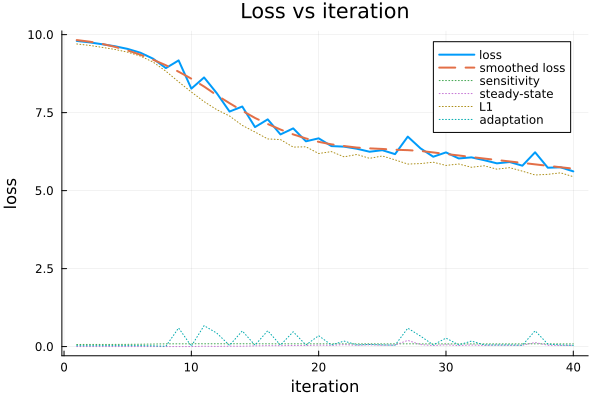

In [2790]:
using Loess
loss_names = ["sensitivity", "steady-state", "L1", "adaptation"]
plot(1:length(loss_tape), loss_tape, label="loss", xlabel="iteration", ylabel="loss", title="Loss vs iteration", lw=2, legend=:topright)
# smooth interpolation of the loss
model = loess(1:length(loss_tape), convert(Vector{Float64}, loss_tape), span=0.5)
predictions = predict(model, 1:length(loss_tape))
plot!(1:length(loss_tape), predictions, label="smoothed loss", lw=2, line=:dash)
for i in 1:n_losses
    #if sum([x[i].val for x in loss_tape_array]) > 0.
    plot!(1:length(loss_tape), [x[i].val for x in loss_tape_array], lw=1, line=:dot, label=loss_names[i])
    #end
end
plot!()

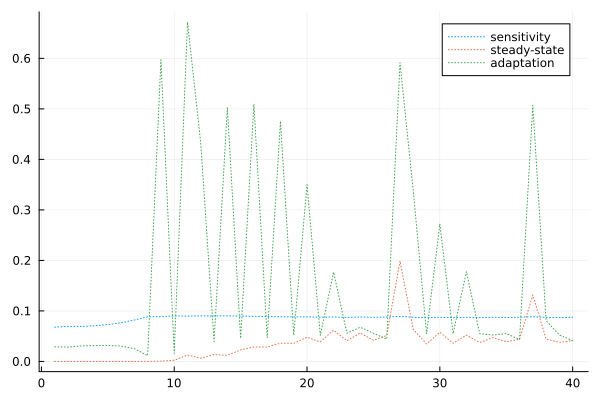

In [2791]:
for i in 1:n_losses
    if i == 3
        continue
    end
    if i == 1
        plot(1:length(loss_tape), [x[i].val for x in loss_tape_array], lw=1, line=:dot, label=loss_names[i])
    else
        plot!(1:length(loss_tape), [x[i].val for x in loss_tape_array], lw=1, line=:dot, label=loss_names[i])
    end
end
plot!()

##### Response on best

Optimal index: 40
Adaptation error: 0.8142718793076629
sensitivity: 0.3452397007330321 and  loss : 0.2452397007330321


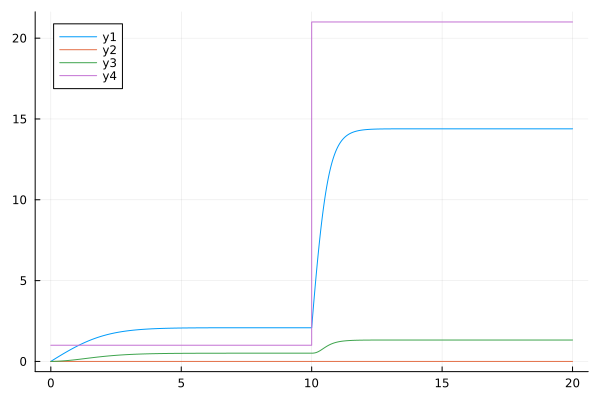

In [2792]:
perturb = 20
#opt_index = argmin(loss_tape)
#opt_index = argmin(predictions)
opt_index = length(loss_tape) 

opt_pars_v = parameter_tape[opt_index]
opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, N)

sol = run_extended_with_fixed_perturbations(ext_ode, opt_pars_l, input, [ perturb ], t0, t1)[1]
println("Optimal index: ", opt_index)
println("Adaptation error: ", abs(sol(t0)[3] - sol(t1)[3]))
println("sensitivity: ", abs(sol(t0)[3] - sol(t0+d)[3]), " and  loss : ", abs(abs(sol(t0)[3] - sol(t0+d)[3]) - p))
plot(sol.t, vec2mat(sol.u)[:,1:4])

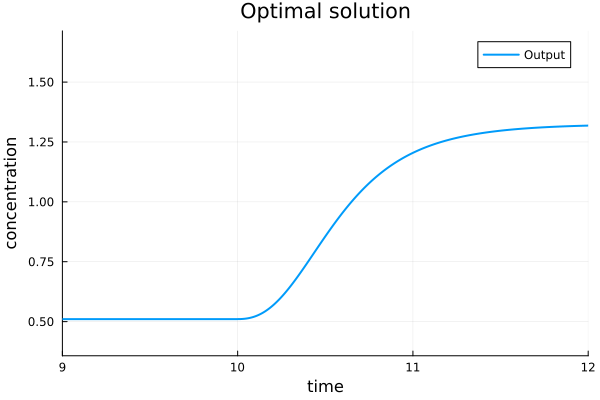

In [2793]:
# zoom on reaction 3
plot(sol.t, vec2mat(sol.u)[:,3], label="Output", xlabel="time", ylabel="concentration", title="Optimal solution", lw=2)
xlims!(t0-1., t0+2)
ylims!(sol(t0-1)[3]-sol(t0-1)[3]*0.3, sol(t0+2)[3]+sol(t0+2)[3]*0.3)

compare the response on the 3rd species for the three options

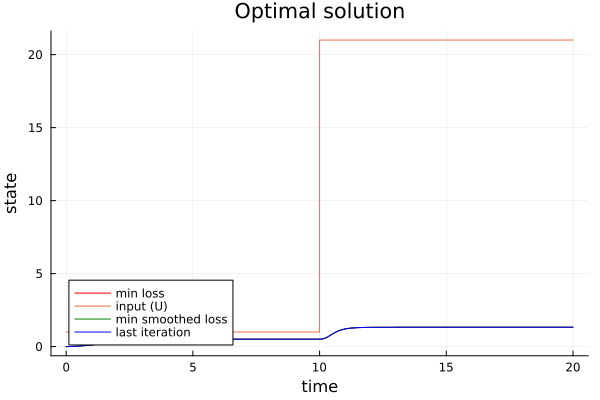

In [2794]:
opt_index_options = [argmin(loss_tape), argmin(predictions), length(loss_tape)]
opt_index_options_labels = ["min loss", "min smoothed loss", "last iteration"]
opt_index_options_colors = [:red, :green, :blue]
for i in 1:length(opt_index_options)
    opt_index = opt_index_options[i]
    opt_pars_v = parameter_tape[opt_index]
    opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, N)
    sol = run_extended_with_fixed_perturbations(ext_ode, opt_pars_l, input, [ perturb ], t0, t1)[1]
    if i == 1
        plot(sol.t, vec2mat(sol.u)[:,3], label=opt_index_options_labels[i], xlabel="time", ylabel="state", title="Optimal solution", lw=1, legend=:bottomleft, color=opt_index_options_colors[i])
        plot!(sol.t, vec2mat(sol.u)[:,4], label="input (U)", lw=1, legend=:bottomleft)
    else
        plot!(sol.t, vec2mat(sol.u)[:,3], label=opt_index_options_labels[i], lw=1, legend=:bottomleft, color=opt_index_options_colors[i])
    end
end
plot!()

##### gradients

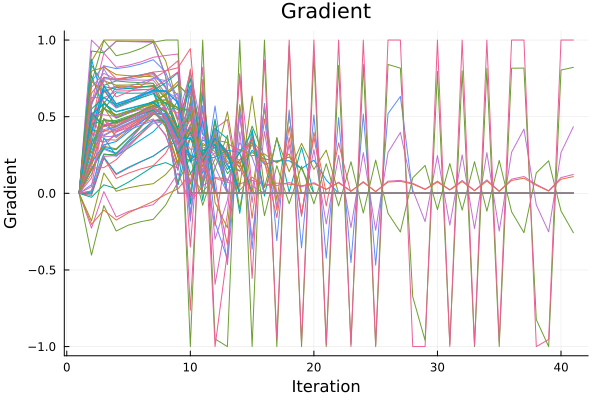

In [2795]:
plot(1:length(gradient_tape), vec2mat(gradient_tape), legend=false, title="Gradient", xlabel="Iteration", ylabel="Gradient")

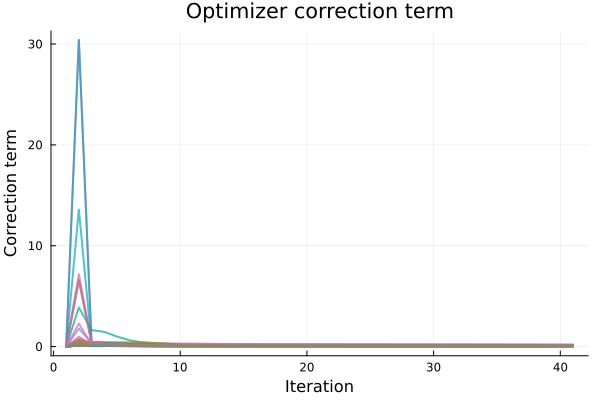

In [2796]:
plot(1:length(optimizer_tape), vec2mat(optimizer_tape), label="Optimizer correction term", xlabel="Iteration", ylabel="Correction term", title="Optimizer correction term", lw=2, legend=false, alpha=0.7)

In [2797]:
vec2mat(gradient_tape)[end,gradient_tape[end].>0]

5-element Vector{Float64}:
 0.4349079886548541
 0.8220761027163985
 0.12314175718185948
 0.1091762515625208
 1.0

##### parameters

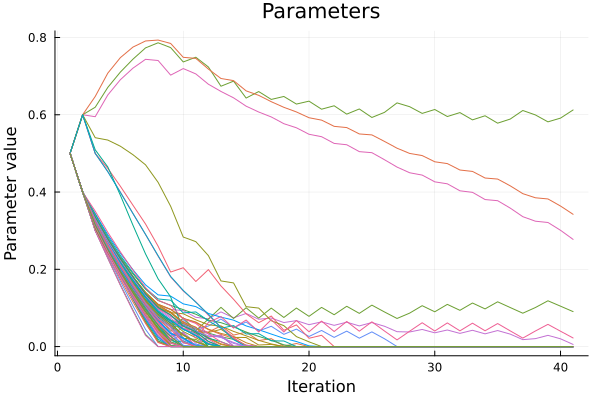

In [2798]:
plot(1:length(parameter_tape), vec2mat(parameter_tape), legend=false, title="Parameters", xlabel="Iteration", ylabel="Parameter value")

prameter histogram

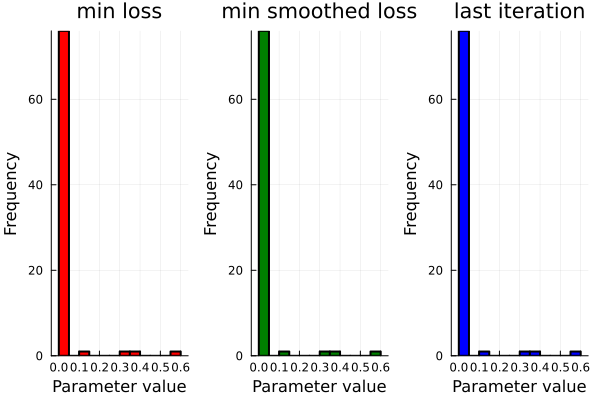

In [2799]:
opt_index_options = [argmin(loss_tape), argmin(predictions), length(loss_tape)]
opt_index_options_labels = ["min loss", "min smoothed loss", "last iteration"]
opt_index_options_colors = [:red, :green, :blue]

hists = []
for i in 1:length(opt_index_options)
    opt_index = opt_index_options[i]
    opt_pars_v = parameter_tape[opt_index]
    opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, N)
    h = histogram(opt_pars_v, label=opt_index_options_labels[i], xlabel="Parameter value", ylabel="Frequency", title=opt_index_options_labels[i], lw=2, legend=false, color=opt_index_options_colors[i], bins=20)
    push!(hists, h)
end
plot(hists..., layout=(1,3))

In [2800]:
vec2mat(gradient_tape)[2,gradient_tape[2].<0]

8-element Vector{Float64}:
 -0.01392422359847786
 -0.22685434044428274
 -0.4033671394331036
 -0.2030863466890836
 -0.0032901000721639335
 -0.025784139076904775
 -0.179802899061003
 -0.0032901000721413643

In [2801]:
gradient_tape[2].>0

80-element BitVector:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1

##### Evaluate adaptation type

In [2802]:
using Symbolics
using LinearAlgebra
function joint_jacobian(i, j, jac, initial_conditions)
    A_ij = substitute(jac[i, j], unsym_dict(initial_conditions))
    return A_ij
end

opt_index = argmin(loss_tape)
# opt_index = argmin(predictions)
# opt_index = length(loss_tape)

opt_pars_v = parameter_tape[opt_index]
opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, N)

jac = Symbolics.substitute(calculate_jacobian(ode_crn), unsym_dict(opt_pars_l.p))

perturb = 1.
steady_state_after_perturbation = run_extended_with_fixed_perturbations(ext_ode, opt_pars_l, input, [ perturb ], t0, t1)[1](t1)[1:3]
steady_state_after_perturbation = [
    :x_1 => steady_state_after_perturbation[1],
    :x_2 => steady_state_after_perturbation[2],
    :x_3 => steady_state_after_perturbation[3]
]

A_21 = joint_jacobian(2, 1, jac, steady_state_after_perturbation)
A_32 = joint_jacobian(3, 2, jac, steady_state_after_perturbation)
A_22 = joint_jacobian(2, 2, jac, steady_state_after_perturbation)
A_31 = joint_jacobian(3, 1, jac, steady_state_after_perturbation)

println("A_21 = ", A_21)
println("A_32 = ", A_32)
println("A_22 = ", A_22)
println("A_31 = ", A_31)
println("A_22*A_31 = ", A_22*A_31)
println("A_21*A_32 = ", A_21*A_32)
println("A_22*A_31 - A_21*A_32 = ", A_22*A_31 - A_21*A_32)

A_21 = -0.0
A_32 = -0.21593496096208484
A_22 = -1.243689809352317
A_31 = 0.12999701572844977
A_22*A_31 = -0.16167596370768583
A_21*A_32 = 0.0
A_22*A_31 - A_21*A_32 = -0.16167596370768583


In [2803]:
Symbolics.substitute(jac, unsym_dict(steady_state_after_perturbation))

3×4 Matrix{Num}:
 -0.727438  -1.02775   -2.01921  1
 -0.0       -1.24369   -0.0      0
  0.129997  -0.215935  -2.01921  0

In [2804]:
steady_state_after_perturbation = run_extended_with_fixed_perturbations(ext_ode, opt_pars_l, input, [ perturb ], t0, t1)[1](t1)[1:3]

3-element Vector{Float64}:
 3.4148487707191157
 0.0
 0.5936589621732702

In [2805]:
# TODO to be fixed
compute_homeostatic_coefficient(crn, calculate_jacobian(ode_crn), [1 for i in 1:np])

(coefficient = -419.54327612949135, A_21 = 10.244398556978787, A_32 = 10.244398556975291, A_22 = -30.709033096051662, A_31 = 10.244398556975291, A_22_A_31 = -314.5955743352981, A_21_A_32 = 104.94770179419324)

### check surviving reactions 

In [2806]:
opt_index = length(loss_tape)
ranks = reverse(sortperm(abs.(parameter_tape[opt_index])))

for i in ranks
    if i != 1
        println(parameter_tape[opt_index][i], " : ", reactions(crn)[2:end][i])
    end
end

0.5913032573452541 : k_32, x_1 + x_3 --> ∅
0.3637357047076134 : k_34, x_2 + x_3 --> ∅
0.30096643142817786 : k_31, x_1 + x_2 --> ∅
0.10462369540901915 : k_16, x_1 --> 2*x_3
0.03979416384791118 : k_55, 2*x_1 --> 2*x_3
0.020139101430837796 : k_4, ∅ --> x_1 + x_3
0.0 : k_80, 2*x_3 --> x_2 + x_3
0.0 : k_79, 2*x_3 --> 2*x_2
0.0 : k_78, 2*x_3 --> x_1 + x_3
0.0 : k_77, 2*x_3 --> x_1 + x_2
0.0 : k_76, 2*x_3 --> 2*x_1
0.0 : k_75, x_2 + x_3 --> 2*x_3
0.0 : k_74, x_2 + x_3 --> 2*x_2
0.0 : k_73, x_2 + x_3 --> x_1 + x_3
0.0 : k_72, x_2 + x_3 --> x_1 + x_2
0.0 : k_71, x_2 + x_3 --> 2*x_1
0.0 : k_70, 2*x_2 --> 2*x_3
0.0 : k_69, 2*x_2 --> x_2 + x_3
0.0 : k_68, 2*x_2 --> x_1 + x_3
0.0 : k_67, 2*x_2 --> x_1 + x_2
0.0 : k_66, 2*x_2 --> 2*x_1
0.0 : k_65, x_1 + x_3 --> 2*x_3
0.0 : k_64, x_1 + x_3 --> x_2 + x_3
0.0 : k_63, x_1 + x_3 --> 2*x_2
0.0 : k_62, x_1 + x_3 --> x_1 + x_2
0.0 : k_61, x_1 + x_3 --> 2*x_1
0.0 : k_60, x_1 + x_2 --> 2*x_3
0.0 : k_59, x_1 + x_2 --> x_2 + x_3
0.0 : k_58, x_1 + x_2 --> 2*x_2


In [2807]:
sensitivity(ode_crn, pars_v)

3×79 Matrix{Num}:
 0  0  1  1  0  -x_1(t)  -x_1(t)   x_2(t)  …   (1//2)*(x_3(t)^2)            0
 1  0  1  0  1   x_1(t)        0  -x_2(t)                      0     x_3(t)^2
 0  1  0  1  1        0   x_1(t)        0     (-1//2)*(x_3(t)^2)  -(x_3(t)^2)

In [2808]:
pars_v = [0. for i in 1:np]
pars_l = assemble_opt_parameters_and_varables(pars_v, N)
sol = run_extended(ext_ode, pars_v, pars_l, input, perturbation, t0, t1)
sm = sensitivity_from_ode(ode_crn, sol, t0)

3×80 Matrix{Float64}:
  0.0   0.0  10.0  10.0   0.0  -50.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 10.0   0.0  10.0   0.0  10.0   50.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0  10.0   0.0  10.0  10.0    0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [2809]:
sm[1, 19]

0.0

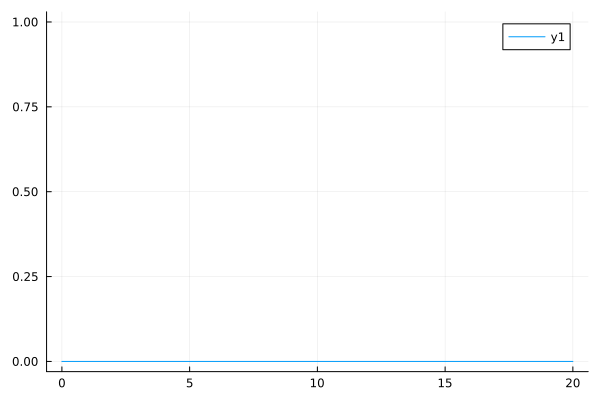

In [2810]:
plot(sol.t, vec2mat(sol.u)[:,3])

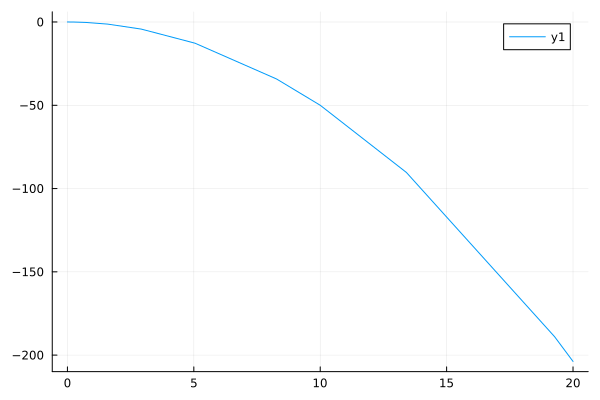

In [2811]:
plot(sol.t, vec2mat(sol.u)[:,10])

In [2812]:
10.0*substitute(compute_symbolic_derivatives_of_loss(s_loss)[o_t0], unsym_dict(Dict(
    :o_t0 => sol(t0)[3],
    :o_t0pdt => sol(t0+d)[3], 
    :o_t1 => sol(t1)[3],
    :p_s => 0.05
)))

10.0(0.9070294784580498w₁ - 0.2899408284023668w₄)

In [2813]:
10.0*substitute(compute_symbolic_derivatives_of_loss(s_loss)[o_t1], unsym_dict(Dict(
    :o_t0 => sol(t0)[3],
    :o_t0pdt => sol(t0+d)[3], 
    :o_t1 => sol(t1)[3],
    :p_s => 0.05
)))

0.5325443786982248w₄

In [2814]:
10.0*substitute(compute_symbolic_derivatives_of_loss(s_loss)[o_t0pdt], unsym_dict(Dict(
    :o_t0 => sol(t0)[3],
    :o_t0pdt => sol(t0+d)[3], 
    :o_t1 => sol(t1)[3],
    :p_s => 0.05
)))

-9.070294784580499w₁

In [2815]:
findall((x) -> isequal(x,:k_54), [ i for i in keys(pars_l.p)])

1-element Vector{Int64}:
 57

In [2816]:
gradient_tape[2]

80-element Vector{Float64}:
 0.582235877234965
 0.6534283717478924
 0.9288075054870725
 1.0
 0.8613713486987997
 0.22575667312255931
 0.36487721615678304
 0.517881618688759
 0.4793239763940302
 0.4128505425788213
 ⋮
 0.38245780916299493
 0.5231031768955322
 0.2336475325515206
 0.5149382680165947
 0.3824578091630301
 0.30805267085729504
 0.3783753547235438
 0.2336475325515599
 0.3039702164178088

In [2817]:
jacobian_pars(ode_crn, loss_args, loss_derivatives, sol, 3, 10., 20., pars_v, 0.5, 0.1, [[Symbol("x_$(i)") for i in 1:3]..., Symbol("U")]).sensitivity

80-element Vector{Num}:
 10.130509086907114
  8.213544932180714
 10.261018173814229
  8.344054019087828
  8.344054019087828
 10.0
  5.524926041399837
 10.0
 10.0
 10.0
  ⋮
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0

In [2818]:
sensitivity(ode_crn, pars_v)[:, 54]

3-element Vector{Num}:
       -(x_1(t)^2)
 (1//2)*(x_1(t)^2)
 (1//2)*(x_1(t)^2)

In [2819]:
jacobian_pars(ode_crn, loss_args, loss_derivatives, sol, 3, 10., 20., pars_v, 0.5, 0.1, [[Symbol("x_$(i)") for i in 1:3]..., Symbol("U")]).sensitivity[54]

31.92286184088414